<a href="https://colab.research.google.com/github/Anjasfedo/data-analysis/blob/main/Copy_of_Template_Submission_Akhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** M. Anjasfedo Afridiansah
- **Email:** fedoafridiansah@gmail.com
- **ID Dicoding:** anjasfedo

## Import Semua Packages/Library yang Digunakan

In [ ]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
import os
import shutil

# Path to the downloaded dataset (original location)
dataset_path = '/kaggle/input/gemstones'

# Define the new path where you want to copy the dataset
combined_dir = '/content/datasets'  # A writable location in Google Colab or other environments

# Create the combined directory at the new location
os.makedirs(combined_dir, exist_ok=True)  # Ensure the directory exists

# List contents of the dataset directory to verify its structure
dataset_contents = os.listdir(dataset_path)
print("Dataset contents:", dataset_contents)

# Directories for train, test, and validation datasets
train_dir = os.path.join(dataset_path, 'FYP_Datasets', 'train')
test_dir = os.path.join(dataset_path, 'FYP_Datasets', 'test')
validation_dir = os.path.join(dataset_path, 'FYP_Datasets', 'validation')

# Verify if the directories exist
print("Train Directory exists:", os.path.exists(train_dir))
print("Test Directory exists:", os.path.exists(test_dir))
print("Validation Directory exists:", os.path.exists(validation_dir))

# Function to copy images from one directory to the combined directory
def copy_images(src_dir, dst_dir):
    if os.path.exists(src_dir):
        for class_name in os.listdir(src_dir):
            class_path = os.path.join(src_dir, class_name)
            if os.path.isdir(class_path):
                # Create class folder in combined_dir
                class_dst = os.path.join(dst_dir, class_name)
                os.makedirs(class_dst, exist_ok=True)
                for file_name in os.listdir(class_path):
                    file_path = os.path.join(class_path, file_name)
                    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        shutil.copy(file_path, os.path.join(class_dst, file_name))  # Copy the image
                        print(f"Copied {file_name} to {class_dst}")
            else:
                print(f"Skipping non-directory {class_name}")
    else:
        print(f"Source directory {src_dir} does not exist")

# Copy images from train, test, and validation directories to the combined directory
copy_images(train_dir, combined_dir)
copy_images(test_dir, combined_dir)
copy_images(validation_dir, combined_dir)

# Verify the combined directory structure
combined_contents = os.listdir(combined_dir)
print("Combined Dataset contents:", combined_contents)

# Check the class distribution in the combined directory
for class_name in os.listdir(combined_dir):
    class_path = os.path.join(combined_dir, class_name)
    if os.path.isdir(class_path):
        print(f"{class_name}: {len(os.listdir(class_path))} images")


Streaming output truncated to the last 5000 lines.
Copied Emerld_90.jpg to /content/datasets/Emerald
Copied Emerld_233.jpg to /content/datasets/Emerald
Copied Emerld_21.jpg to /content/datasets/Emerald
Copied Emerld_69.jpg to /content/datasets/Emerald
Copied Emerld_406.jpg to /content/datasets/Emerald
Copied Emerld_408.jpg to /content/datasets/Emerald
Copied Emerld_419.jpg to /content/datasets/Emerald
Copied Emerld_169.jpg to /content/datasets/Emerald
Copied Emerld_377.jpg to /content/datasets/Emerald
Copied Emerld_193.jpg to /content/datasets/Emerald
Copied Emerld_389.jpg to /content/datasets/Emerald
Copied Emerld_277.jpg to /content/datasets/Emerald
Copied Emerld_111.jpg to /content/datasets/Emerald
Copied Emerld_195.jpg to /content/datasets/Emerald
Copied Emerld_73.jpg to /content/datasets/Emerald
Copied Emerld_49.jpg to /content/datasets/Emerald
Copied Emerld_344.jpg to /content/datasets/Emerald
Copied Emerld_108.jpg to /content/datasets/Emerald
Copied Emerld_417.jpg to /content/da

Classes in dataset: dict_keys(['Fake_Ruby', 'Emerald', 'Ruby', 'Fake_Turquoise', 'Turquoise', 'Fake_Emerald'])
Fake_Ruby: 1036 images
Emerald: 1007 images
Ruby: 1000 images
Fake_Turquoise: 999 images
Turquoise: 1000 images
Fake_Emerald: 1000 images


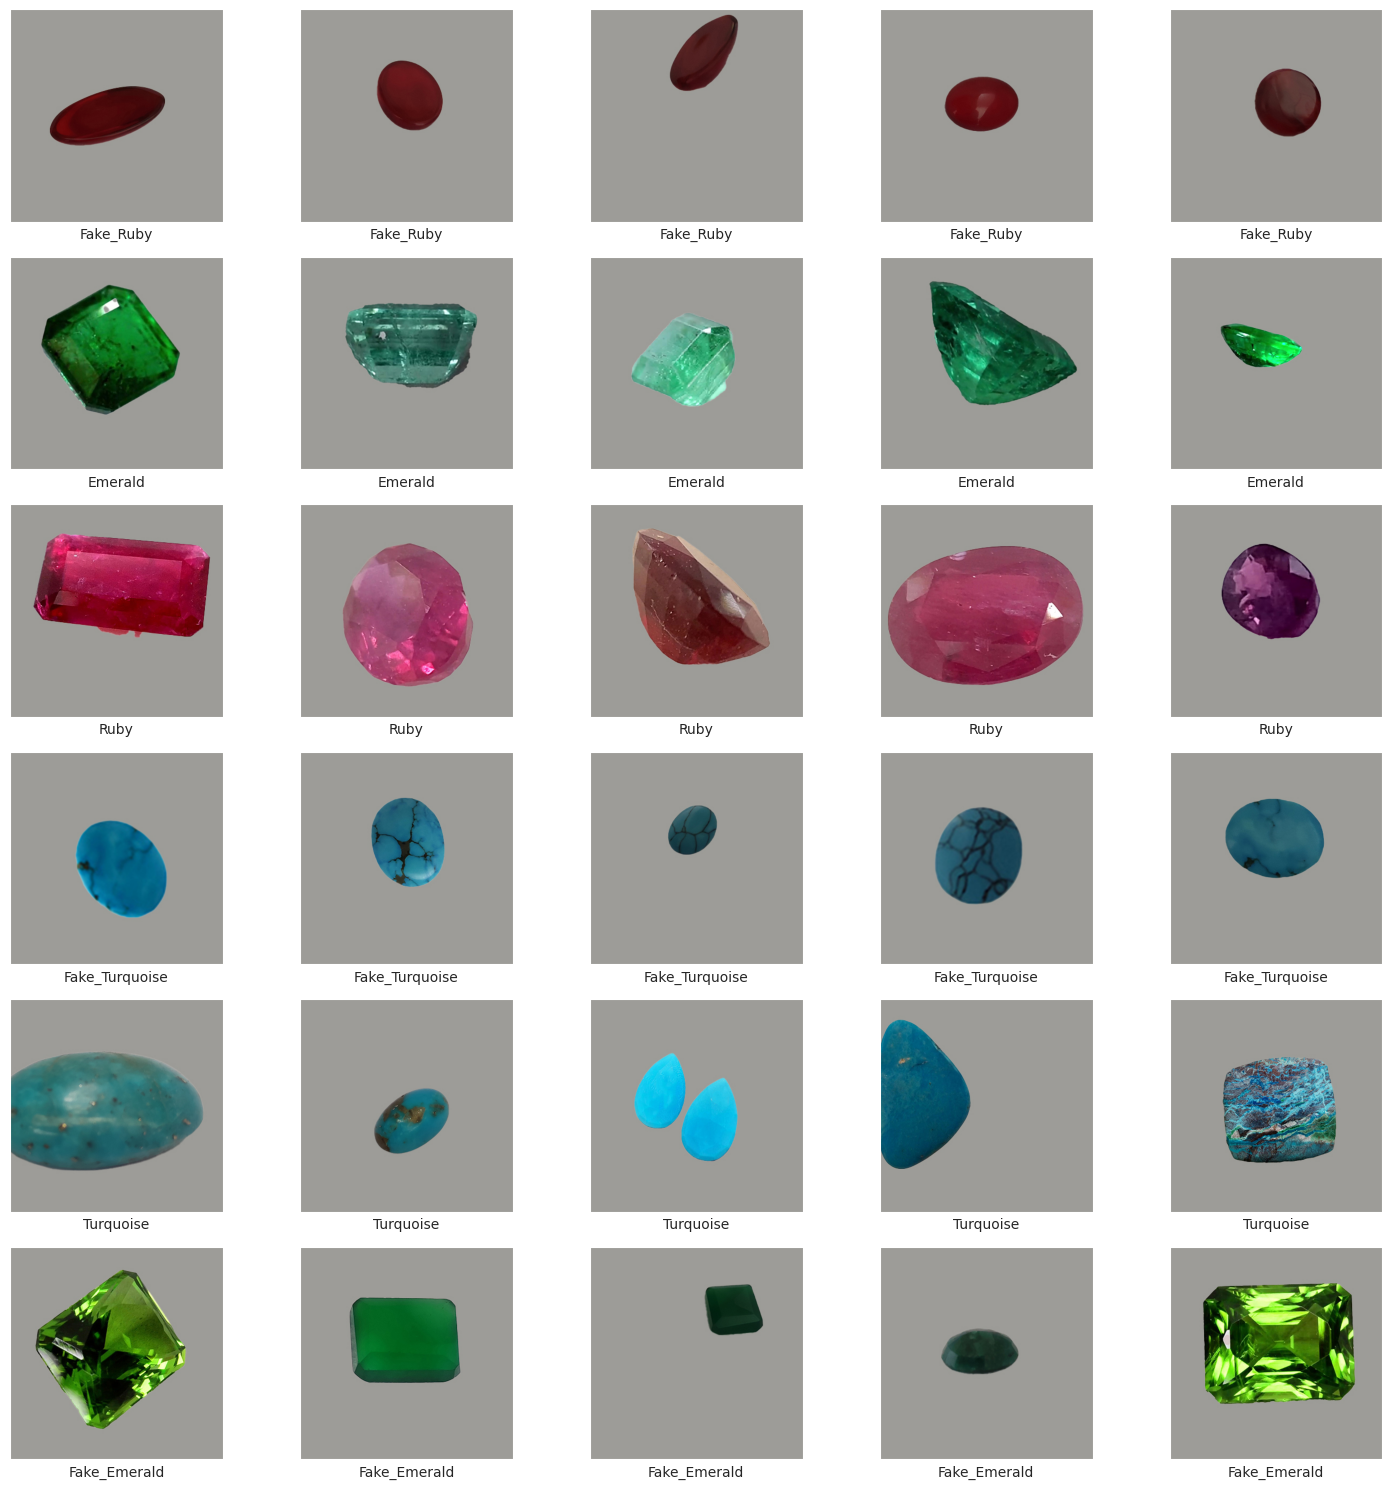

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path to the combined dataset directory (after moving images)
combined_dir = '/content/datasets'  # Path where the dataset was copied/moved

# Dictionary to store images for each class (i.e., gemstones type)
gemstone_images = {}

# Loop through the subdirectories (classes) and list image files for each class
for class_name in os.listdir(combined_dir):
    class_path = os.path.join(combined_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory (class folder)
        gemstone_images[class_name] = os.listdir(class_path)

# Verify the structure by printing the number of images in each class
print("Classes in dataset:", gemstone_images.keys())
for class_name in gemstone_images:
    print(f"{class_name}: {len(gemstone_images[class_name])} images")

# Display 5 random images for each class
fig, axs = plt.subplots(len(gemstone_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(gemstone_images.keys()):
    images = np.random.choice(gemstone_images[class_name], 5, replace=False)  # Randomly choose 5 images

    for j, image_name in enumerate(images):
        img_path = os.path.join(combined_dir, class_name, image_name)  # Full path to the image
        img = Image.open(img_path)  # Open the image as RGB (no conversion to grayscale)
        axs[i, j].imshow(img)  # Show the RGB image
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

# Adjust layout for better presentation
fig.tight_layout()
plt.show()


Processing class: Fake_Ruby
Processing class: Emerald
Processing class: Ruby
Processing class: Fake_Turquoise
Processing class: Turquoise
Processing class: Fake_Emerald
                                                path              file_name  \
0  /content/datasets/Fake_Ruby/(400, 400, 3)_668.jpg  (400, 400, 3)_668.jpg   
1  /content/datasets/Fake_Ruby/(400, 400, 3)_746.jpg  (400, 400, 3)_746.jpg   
2  /content/datasets/Fake_Ruby/(400, 400, 3)_695.jpg  (400, 400, 3)_695.jpg   
3  /content/datasets/Fake_Ruby/(400, 400, 3)_306.jpg  (400, 400, 3)_306.jpg   
4  /content/datasets/Fake_Ruby/(400, 400, 3)_918.jpg  (400, 400, 3)_918.jpg   

      labels  
0  Fake_Ruby  
1  Fake_Ruby  
2  Fake_Ruby  
3  Fake_Ruby  
4  Fake_Ruby  
labels
Fake_Ruby         1036
Emerald           1007
Ruby              1000
Turquoise         1000
Fake_Emerald      1000
Fake_Turquoise     999
Name: count, dtype: int64


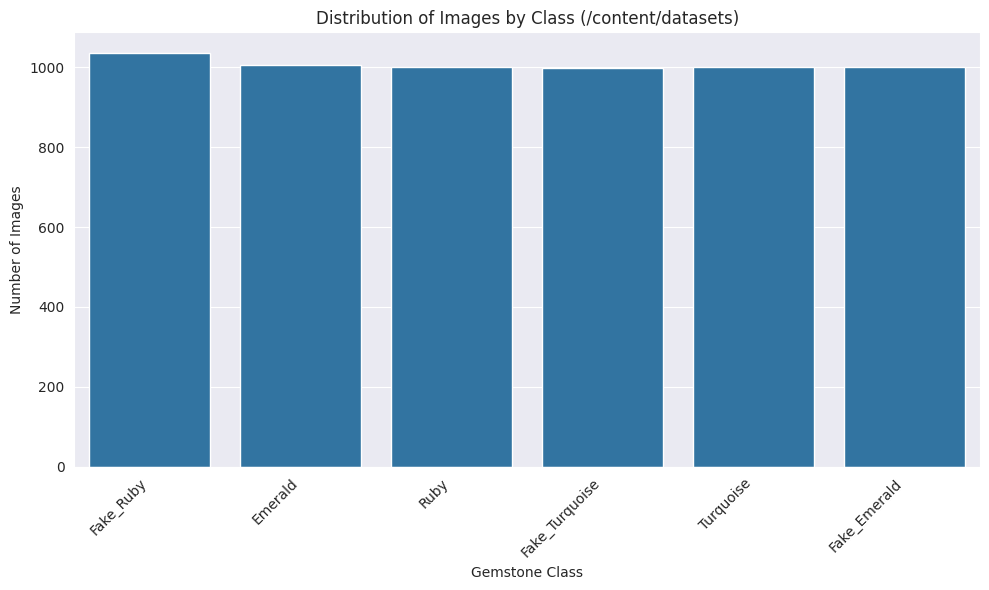

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the distribution of images across classes
def plot_distribution(dataset_dir):
    # Create lists to store file names, labels (classes), and file paths
    file_name = []
    labels = []
    full_path = []

    # Loop through the dataset directory and gather the file information
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)

        # Ensure the class path is a directory
        if os.path.isdir(class_path):
            print(f"Processing class: {class_name}")
            for name in os.listdir(class_path):
                # Check if the file has an image extension (you can modify this list as needed)
                if name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    full_path.append(os.path.join(class_path, name))  # Full path to the image
                    labels.append(class_name)  # Class label (gemstone type)
                    file_name.append(name)  # Image file name
                else:
                    print(f"Skipping non-image file: {name}")

    # If images were found, create a DataFrame
    if full_path:
        distribution = pd.DataFrame({
            "path": full_path,
            "file_name": file_name,
            "labels": labels
        })

        # Print the first few rows to verify
        print(distribution.head())

        # Optionally, check the number of images per class
        print(distribution['labels'].value_counts())

        # Plot the distribution of images across different classes
        plt.figure(figsize=(10, 6))
        sns.set_style("darkgrid")
        plot_data = sns.countplot(x='labels', data=distribution)
        plot_data.set_title(f'Distribution of Images by Class ({dataset_dir})')
        plot_data.set_xlabel('Gemstone Class')
        plot_data.set_ylabel('Number of Images')
        plt.xticks(rotation=45, ha='right')  # Rotate class labels for better readability
        plt.tight_layout()
        plt.show()

    else:
        print("No images found in the specified dataset.")

# Path to the combined dataset (after moving images)
combined_dataset_path = '/content/datasets'  # Combined dataset path (e.g., after merging train, test, and validation)
# Plot distribution for the combined dataset
plot_distribution(combined_dataset_path)


### Data Preprocessing

In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [ ]:
# Dictionary to store transformations
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Path to the combined dataset directory (where you want to save the augmented images)
dataset_path = '/content/datasets'  # Path where the dataset is saved (combined train/test/validation)

# List to store images
images = []

# Loop through the dataset, process class-wise
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):  # Ensure it's a directory (class folder)
        print(f"Processing class: {class_name}")

        # Read image filenames and add full paths to images list
        for name in os.listdir(class_path):
            if name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Only include image files
                images.append(os.path.join(class_path, name))

        # Number of images to generate with augmentation for this class
        images_to_generate = 500  # Example: Generate 500 augmented images per class
        i = 1

        while i <= images_to_generate:
            # Randomly choose an image from the class
            image_path = random.choice(images)

            try:
                # Read the image
                original_image = io.imread(image_path)
                transformed_image = None
                n = 0  # Counter for transformations to apply
                transformation_count = random.randint(1, len(transformations))  # Randomly choose how many transformations to apply

                while n < transformation_count:
                    key = random.choice(list(transformations))  # Choose a random transformation
                    transformed_image = transformations[key](original_image)
                    n += 1

                # Save the transformed image directly in the original class folder
                new_image_path = f"{class_path}/{class_name}_augmented_image_{i}.jpg"
                transformed_image = img_as_ubyte(transformed_image)  # Convert to unsigned byte format for saving
                cv2.imwrite(new_image_path, transformed_image)  # Save the augmented image
                i += 1
            except ValueError as e:
                print(f"Could not read the image {image_path}: {e}. Skipping it.")

Processing class: Fake_Ruby
Processing class: Emerald
Processing class: Ruby
Processing class: Fake_Turquoise
Processing class: Turquoise
Processing class: Fake_Emerald


Processing class: Fake_Ruby
Processing class: Emerald
Processing class: Ruby
Processing class: Fake_Turquoise
Processing class: Turquoise
Processing class: Fake_Emerald
                                                path              file_name  \
0  /content/datasets/Fake_Ruby/(400, 400, 3)_668.jpg  (400, 400, 3)_668.jpg   
1  /content/datasets/Fake_Ruby/(400, 400, 3)_746.jpg  (400, 400, 3)_746.jpg   
2  /content/datasets/Fake_Ruby/(400, 400, 3)_695.jpg  (400, 400, 3)_695.jpg   
3  /content/datasets/Fake_Ruby/(400, 400, 3)_306.jpg  (400, 400, 3)_306.jpg   
4  /content/datasets/Fake_Ruby/(400, 400, 3)_918.jpg  (400, 400, 3)_918.jpg   

      labels  
0  Fake_Ruby  
1  Fake_Ruby  
2  Fake_Ruby  
3  Fake_Ruby  
4  Fake_Ruby  
labels
Fake_Ruby         1536
Emerald           1507
Ruby              1500
Turquoise         1500
Fake_Emerald      1500
Fake_Turquoise    1499
Name: count, dtype: int64


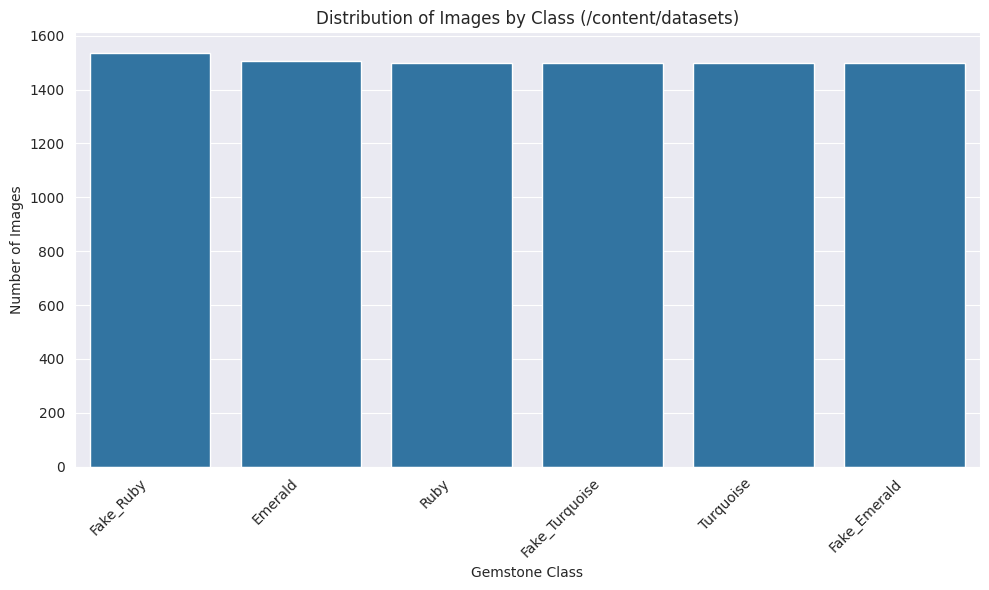

In [ ]:
  # Path to the combined dataset (after moving images)
combined_dataset_path = '/content/datasets'  # Combined dataset path (e.g., after merging train, test, and validation)
# Plot distribution for the combined dataset
plot_distribution(combined_dataset_path)

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/datasets'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Emerald,1507
Fake_Emerald,1500
Fake_Ruby,1536
Fake_Turquoise,1499
Ruby,1500
Turquoise,1500


In [ ]:
# Variables to hold image paths (X) and labels (y)
X = df['path']
y = df['labels']

# Split the dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

# Now, we want to split the train set further into train (80% of the original data) and validation (20% of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=300)

In [ ]:
# Create DataFrames for train, test, and validation sets
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'validation'})

In [ ]:
# Combine all sets into one DataFrame
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

# Print the distribution of data across train, test, and validation sets
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Sample output to check a few rows
print(df_all.sample(5))

# Set the dataset source path and the final dataset path
datasource_path = "/content/datasets/"
dataset_path = "/content/dataset-final/"


set         labels        
test        Emerald           294
            Fake_Emerald      309
            Fake_Ruby         301
            Fake_Turquoise    315
            Ruby              290
            Turquoise         300
train       Emerald           966
            Fake_Emerald      954
            Fake_Ruby         993
            Fake_Turquoise    952
            Ruby              950
            Turquoise         971
validation  Emerald           247
            Fake_Emerald      237
            Fake_Ruby         242
            Fake_Turquoise    232
            Ruby              260
            Turquoise         229
dtype: int64 


                                                   path          labels    set
683         /content/datasets/Turquoise/Turqoise_97.jpg       Turquoise  train
6185  /content/datasets/Fake_Turquoise/(400, 400, 3)...  Fake_Turquoise   test
380   /content/datasets/Fake_Ruby/(400, 400, 3)_356.jpg       Fake_Ruby  train
5146                /content

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Define directories for training and testing sets based on your combined dataset
TRAIN_DIR = "/content/dataset-final/train/"
TEST_DIR = "/content/dataset-final/test/"
VALIDATION_DIR = "/content/dataset-final/validation/"

# List all the classes from the dataset
classes = ['Fake_Emerald', 'Ruby', 'Turquoise', 'Fake_Ruby', 'Fake_Turquoise', 'Emerald']

# Loop through the classes and print the number of images in each class for train and test
for class_name in classes:
    train_class_dir = os.path.join(TRAIN_DIR, class_name)
    test_class_dir = os.path.join(TEST_DIR, class_name)
    validation_class_dir = os.path.join(VALIDATION_DIR, class_name)

    # Check and print the number of images in each class directory
    if os.path.exists(train_class_dir):
        print(f"Total number of {class_name} images in training set: {len(os.listdir(train_class_dir))}")
    else:
        print(f"{class_name} class is missing from the training set.")

    if os.path.exists(test_class_dir):
        print(f"Total number of {class_name} images in test set: {len(os.listdir(test_class_dir))}")
    else:
        print(f"{class_name} class is missing from the test set.")

    if os.path.exists(validation_class_dir):
        print(f"Total number of {class_name} images in validation set: {len(os.listdir(validation_class_dir))}")
    else:
        print(f"{class_name} class is missing from the validation set.")


Total number of Fake_Emerald images in training set: 1191
Total number of Fake_Emerald images in test set: 309
Total number of Fake_Emerald images in validation set: 237
Total number of Ruby images in training set: 1210
Total number of Ruby images in test set: 290
Total number of Ruby images in validation set: 260
Total number of Turquoise images in training set: 1200
Total number of Turquoise images in test set: 300
Total number of Turquoise images in validation set: 229
Total number of Fake_Ruby images in training set: 1235
Total number of Fake_Ruby images in test set: 301
Total number of Fake_Ruby images in validation set: 242
Total number of Fake_Turquoise images in training set: 1184
Total number of Fake_Turquoise images in test set: 315
Total number of Fake_Turquoise images in validation set: 232
Total number of Emerald images in training set: 1213
Total number of Emerald images in test set: 294
Total number of Emerald images in validation set: 247


In [ ]:

# Create ImageDataGenerator for training with rescaling and validation split
datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)  # 20% of the data used for validation

# Create ImageDataGenerator for testing with rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

# RGB Images for the training set
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),  # Resize images to 150x150
    color_mode="rgb",  # Use RGB color mode instead of grayscale
    class_mode='categorical',  # categorical classification (adjust based on your dataset)
    subset='training',  # Use the training subset
    shuffle=True  # Shuffle images for training
)

# RGB Images for the validation set (using VALIDATION_DIR)
validation_generator = datagen.flow_from_directory(
    VALIDATION_DIR,  # Use the validation directory
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",  # Use RGB color mode
    class_mode='categorical',  # categorical classification (adjust based on your dataset)
    shuffle=False  # Don't shuffle images for validation
)

# RGB Images for the testing set
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,  # Test batch size (1 sample per batch)
    target_size=(150, 150),  # Resize images to 150x150
    color_mode="rgb",  # Use RGB color mode
    class_mode='categorical',  # categorical classification (adjust based on your dataset)
    shuffle=False  # Don't shuffle images for testing
)

Found 5788 images belonging to 6 classes.
Found 1447 images belonging to 6 classes.
Found 1809 images belonging to 6 classes.


## Modelling

In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))  # 3 channels for RGB
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(6, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',  # Multi-class classification
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
# Calculate class weights based on class frequency (for handling class imbalance)
count_class_0 = len(os.listdir(os.path.join(TRAIN_DIR, 'Fake_Emerald')))
count_class_1 = len(os.listdir(os.path.join(TRAIN_DIR, 'Ruby')))
count_class_2 = len(os.listdir(os.path.join(TRAIN_DIR, 'Turquoise')))
count_class_3 = len(os.listdir(os.path.join(TRAIN_DIR, 'Fake_Ruby')))
count_class_4 = len(os.listdir(os.path.join(TRAIN_DIR, 'Fake_Turquoise')))
count_class_5 = len(os.listdir(os.path.join(TRAIN_DIR, 'Emerald')))

# Calculate class weights
total_samples = count_class_0 + count_class_1 + count_class_2 + count_class_3 + count_class_4 + count_class_5
weight_0 = (total_samples / count_class_0) / 6
weight_1 = (total_samples / count_class_1) / 6
weight_2 = (total_samples / count_class_2) / 6
weight_3 = (total_samples / count_class_3) / 6
weight_4 = (total_samples / count_class_4) / 6
weight_5 = (total_samples / count_class_5) / 6

class_weights = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3, 4: weight_4, 5: weight_5}

# Training the model with class weights
history_1 = model_1.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights  # Use class weights to handle class imbalance
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 25/181 ━━━━━━━━━━━━━━━━━━━━ 7:32 3s/step - accuracy: 0.2573 - loss: 4.7587

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluasi dan Visualisasi

In [ ]:
# Reset the test generator
test_generator.reset()

# Generate predictions on the test set
preds_1 = model_1.predict(test_generator, verbose=0)

# Get the class with the highest probability (argmax) for each prediction
preds_1 = np.argmax(preds_1, axis=1)

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, preds_1, labels=[0, 1, 2, 3, 4, 5])  # Adjust for 6 classes
cm_df = pd.DataFrame(data=cm,
                     index=["Actual Fake_Emerald", "Actual Ruby", "Actual Turquoise",
                            "Actual Fake_Ruby", "Actual Fake_Turquoise", "Actual Emerald"],
                     columns=["Predicted Fake_Emerald", "Predicted Ruby", "Predicted Turquoise",
                              "Predicted Fake_Ruby", "Predicted Fake_Turquoise", "Predicted Emerald"])

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(test_generator.classes, preds_1, target_names=['Fake_Emerald', 'Ruby', 'Turquoise',
                                                                          'Fake_Ruby', 'Fake_Turquoise', 'Emerald'], digits=4))

## Konversi Model

## Inference (Optional)